In [1]:
# Import components
import datetime as dt
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from matplotlib import pyplot as pltw
from pmdarima import arima, datasets, model_selection, utils
from scipy.spatial import distance
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL

warnings.simplefilter("ignore")

plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"
plt.style.use("ggplot")  # グラフのスタイル
plt.rcParams["figure.figsize"] = [12, 9]  # グラフサイズ設定

In [11]:
def DDTW(Q, C):
    """
    Args:
        Q (np.array or list): 一つ目の波形
        C (np.array or list): 二つ目の波形

    Returns:
        γ_mat (np.array): DDTWを計算するための行列
        arrows (np.array): 各時点で←・↙︎・↓のどのマスが最小だったかを示す記号を保存する行列
        ddtw (float): DDTW
    """
    Q, C = np.array(Q), np.array(C)
    assert Q.shape[0] > 3, "一つ目の波形のフォーマットがおかしいです。"
    assert C.shape[0] > 3, "二つ目の波形のフォーマットがおかしいです。"

    # 3.1 Algorithm details の式
    def _Dq(q):
        return ((q[1] - q[0]) + (q[2] - q[0]) / 2) / 2

    # 二つの時点間の距離
    def _γ(x, y):
        return abs(_Dq(x) - _Dq(y))

    # 各変数
    n, m = Q.shape[0] - 2, C.shape[0] - 2
    γ_mat = np.zeros((n, m))
    arrows = np.array(np.zeros((n, m)), dtype=str)  # 可視化用の行列でDDTWの値とは無関係

    # 一番左下のスタート地点
    γ_mat[0, 0] = _γ(Q[0:3], C[0:3])

    # 一列目を計算
    for i in range(1, n):
        γ_mat[i, 0] = γ_mat[i - 1, 0] + _γ(Q[i - 1 : i + 2], C[0:3])
        arrows[i, 0] = "↓"

    # 一行目を計算
    for j in range(1, m):
        γ_mat[0, j] = γ_mat[0, j - 1] + _γ(Q[0:3], C[j - 1 : j + 2])
        arrows[0, j] = "←"

    # 残りのマスを計算
    for i in range(1, n):
        for j in range(1, m):
            # DDTWを求めるためのマトリクスを埋める
            d_ij = _γ(Q[i - 1 : i + 2], C[j - 1 : j + 2])
            γ_mat[i, j] = d_ij + np.min(
                [γ_mat[i - 1, j - 1], γ_mat[i - 1, j], γ_mat[i, j - 1]]
            )

            # 矢印を書くための行列(DDTWの値とは関係無い処理)
            if (
                square_index := np.argmin(
                    [γ_mat[i - 1, j - 1], γ_mat[i - 1, j], γ_mat[i, j - 1]]
                )
            ) == 0:
                arrows[i, j] = "↙︎"
            elif square_index == 1:
                arrows[i, j] = "↓"
            elif square_index == 2:
                arrows[i, j] = "←"

    return γ_mat, arrows, γ_mat[n - 1, m - 1]

In [2]:
df = pd.read_csv("../datasets/fixed_battery_log_2.csv")
df["date"] = pd.to_datetime(df["date"])
users = df["User"].unique()

In [3]:
df.head()

,User,date,battery,state,weekday,time_to_num
0,Narita,2021-12-04 01:52:00,60,ON,5,6773
1,Narita,2021-12-04 02:22:00,73,OFF,5,8566
2,Narita,2021-12-04 07:06:00,71,ON,5,25564
3,Narita,2021-12-04 07:15:00,73,OFF,5,26105
4,Narita,2021-12-04 07:15:00,73,ON,5,26113


In [4]:
hoge = pd.DataFrame(
    df.loc[(df["User"] == "Narita") & (df["state"] == "ON") & (df["weekday"] == 5)][
        "battery"
    ].copy()
)

In [5]:
foo = pd.DataFrame(
    df.loc[(df["User"] == "Narita") & (df["state"] == "ON") & (df["weekday"] == 1)][
        "battery"
    ].copy()
)

In [6]:
bins = np.linspace(0, 100, 11)
freq_1 = hoge["battery"].value_counts(bins=bins, sort=False)
rel_freq_1 = freq_1 / hoge["battery"].count()
class_value = (bins[:-1] + bins[1:]) / 2

freq_2 = foo["battery"].value_counts(bins=bins, sort=False)
rel_freq_2 = freq_2 / foo["battery"].count()

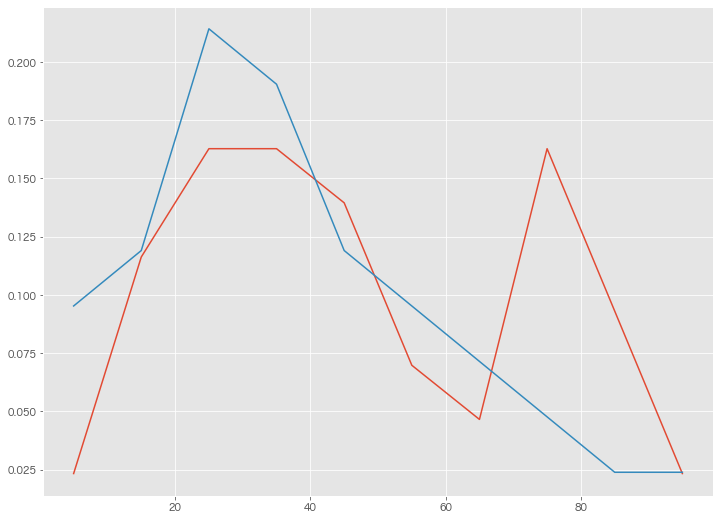

In [7]:
plt.plot(class_value, rel_freq_1)
plt.plot(class_value, rel_freq_2)

In [8]:
date_num = {}

for i in range(0, 7):
    baa = pd.DataFrame(
        df.loc[(df["User"] == "Narita") & (df["state"] == "ON") & (df["weekday"] == i)][
            "battery"
        ].copy()
    )
    freq_pra = baa["battery"].value_counts(bins=bins, sort=False)
    rel_freq_pra = freq_pra / baa["battery"].count()
    date_num[i] = rel_freq_pra.values

In [65]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
first_date = first_date_cand[np.random.randint(0, len(first_date_cand), 1)]
last_date = first_date + dt.timedelta(days=14)

In [66]:
t_Q = pd.DataFrame(
    df.loc[
        (df["User"] == "Narita")
        & (df["state"] == "ON")
        & (df["date"] > first_date[0] + dt.timedelta(seconds=1))
        & (df["date"] < last_date[0])
        & (df["weekday"] == 5)
    ]["battery"].copy()
)
freq_pra = t_Q["battery"].value_counts(bins=bins, sort=False)
rel_freq_pra = freq_pra / t_Q["battery"].count()
t_Q_num = rel_freq_pra.values

In [67]:
t_T = pd.DataFrame(
    df.loc[
        (df["User"] == "Narita")
        & (df["state"] == "ON")
        & (df["date"] > (first_date[0] - dt.timedelta(days=14)))
        & (df["date"] < (first_date[0]))
        & (df["weekday"] == 5)
    ]["battery"].copy()
)
freq_pra = t_T["battery"].value_counts(bins=bins, sort=False)
rel_freq_pra = freq_pra / t_T["battery"].count()
t_T_num = rel_freq_pra.values

In [68]:
i_Q = pd.DataFrame(
    df.loc[
        (df["User"] == "Ayumi")
        & (df["state"] == "ON")
        & (df["date"] > (first_date[0] - dt.timedelta(days=30)))
        & (df["date"] < (first_date[0]))
        & (df["weekday"] == 5)
    ]["battery"].copy()
)
freq_pra = i_Q["battery"].value_counts(bins=bins, sort=False)
rel_freq_pra = freq_pra / i_Q["battery"].count()
i_Q_num = rel_freq_pra.values

In [76]:
weekdays = df["weekday"].unique()
np.random.choice(weekdays)

3

0.652230971128609


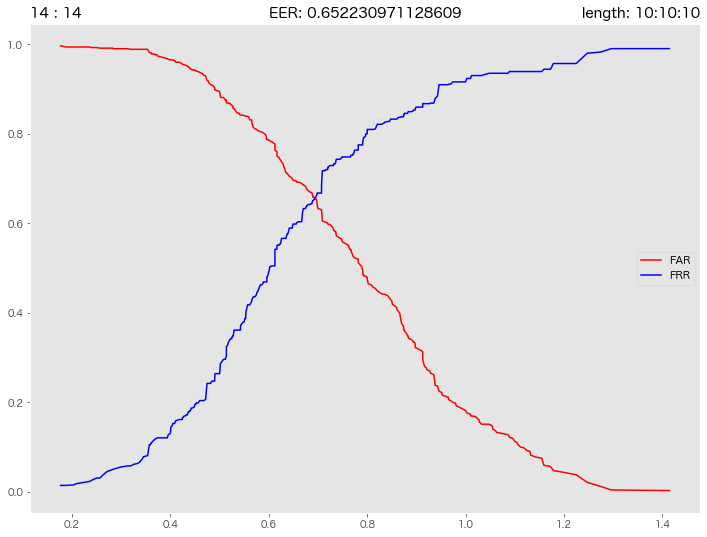

0.6511475409836066


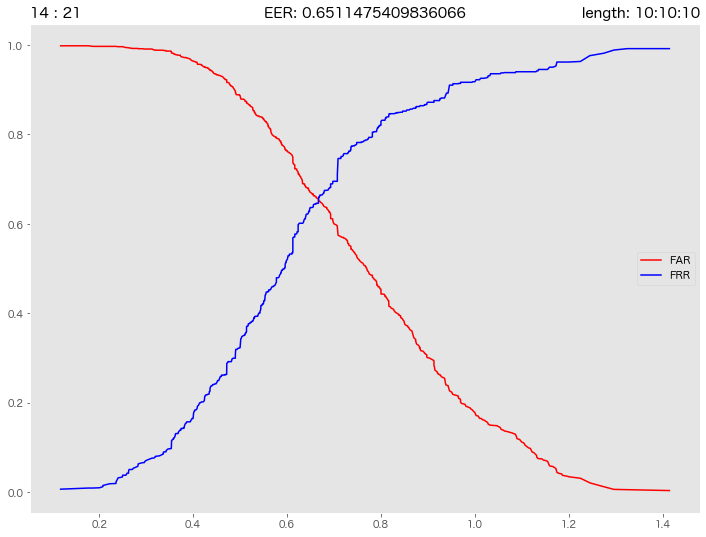

0.6512035010940919


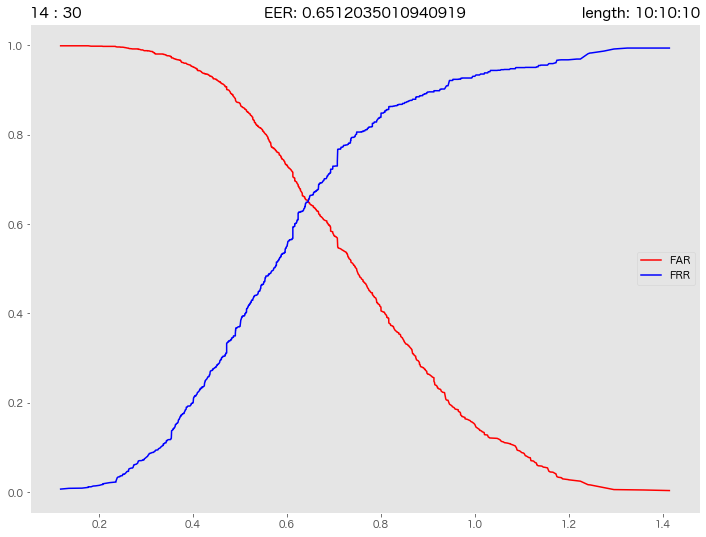

0.6582113821138211


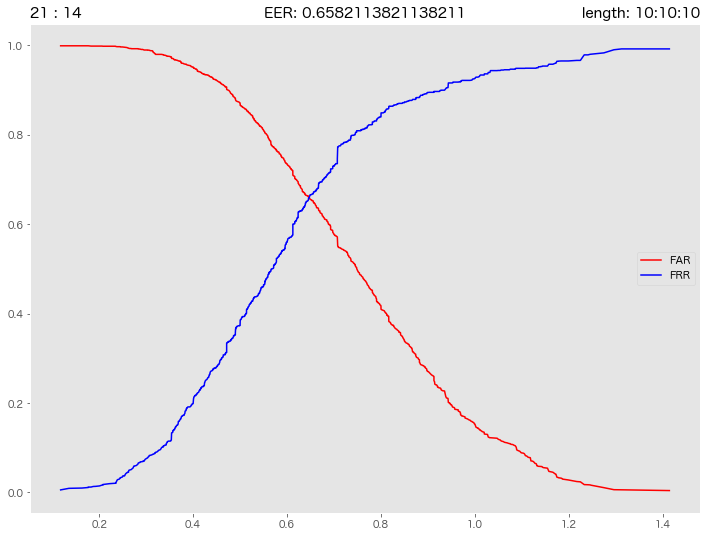

0.6497160557563242


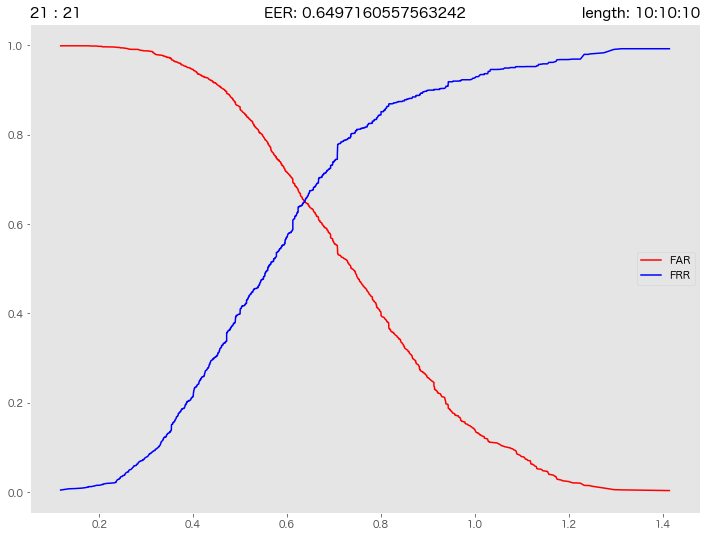

0.6488337256580355


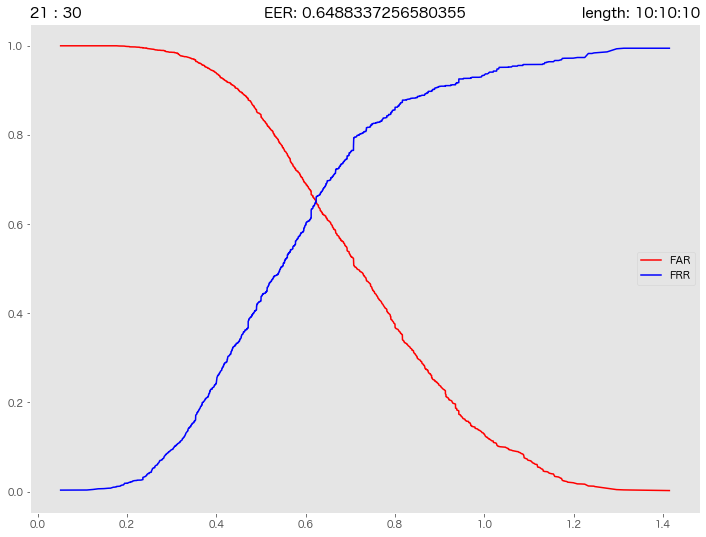

0.6497805413313826


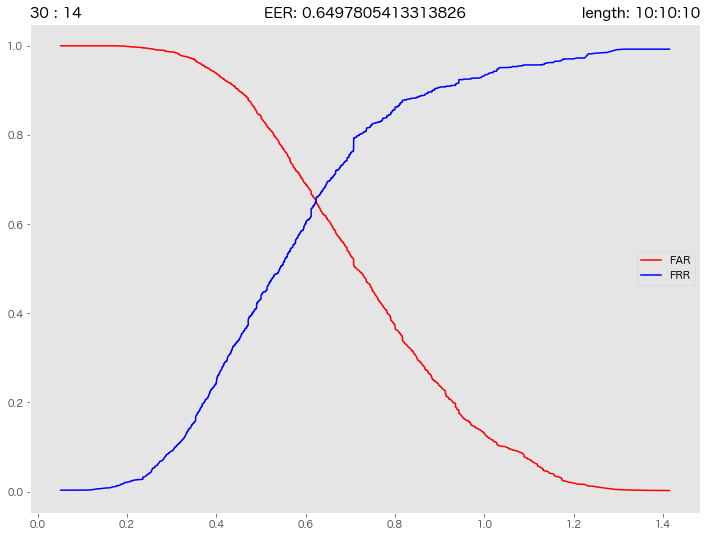

0.6499840612049729


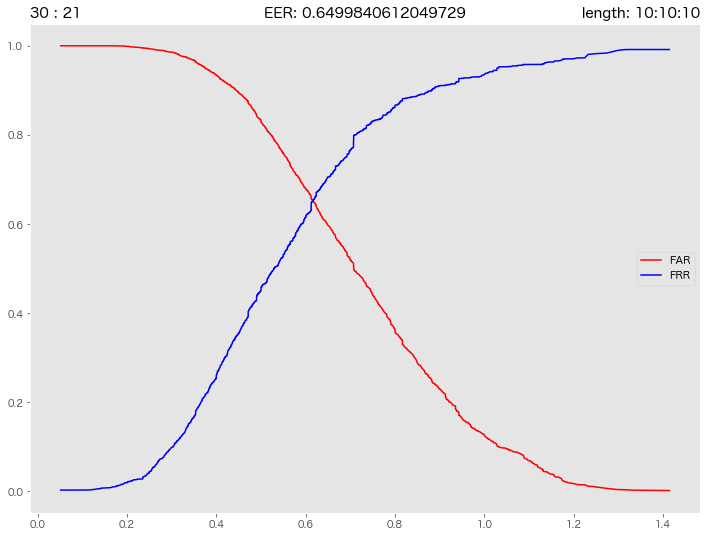

0.6463276836158192


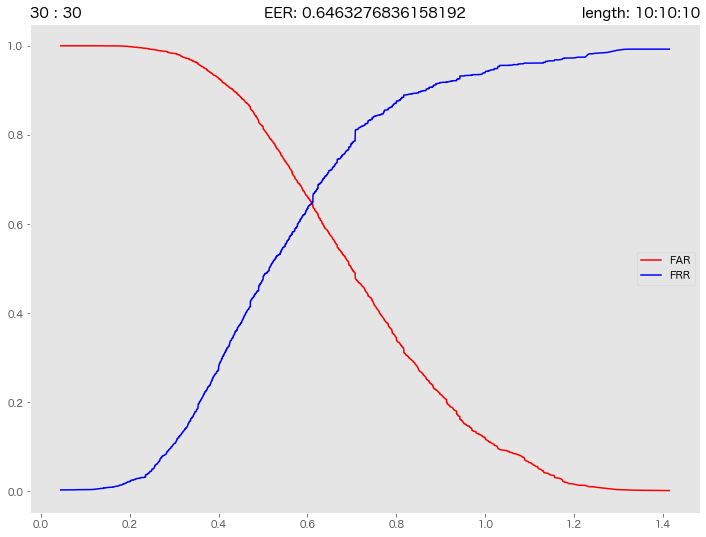

In [84]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G = []
score_I = []

days = [14, 21, 30]
weekdays = df["weekday"].unique()
data = df
clf = LocalOutlierFactor(n_neighbors=3)
bins = np.linspace(0, 100, 11)

for a in range(len(days)):
    diff_day_1 = days[a]
    for b in range(len(days)):
        diff_day_2 = days[b]
        for h in range(len(users)):
            user = users[h]
            for i in range(0, 101):
                first_date = first_date_cand[
                    np.random.randint(0, len(first_date_cand), 1)
                ]
                last_date = first_date + dt.timedelta(days=diff_day_1)
                weekday = np.random.choice(weekdays)
                imposters = users.copy()
                imposters = imposters[~(imposters == user)]
                imposter = np.random.choice(imposters)

                t_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                        & (data["weekday"] == weekday)
                    ]["battery"].copy()
                )

                freq_1 = t_Q["battery"].value_counts(bins=bins, sort=False)
                t_Q = freq_1 / t_Q["battery"].count()

                t_T = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (
                            data["date"]
                            > (first_date[0] - dt.timedelta(days=diff_day_2))
                        )
                        & (data["date"] < (first_date[0]))
                        & (data["weekday"] == weekday)
                    ]["battery"].copy()
                )
                freq_2 = t_T["battery"].value_counts(bins=bins, sort=False)
                t_T = freq_2 / t_T["battery"].count()

                i_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == imposter)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                        & (data["weekday"] == weekday)
                    ]["battery"].copy()
                )
                freq_3 = i_Q["battery"].value_counts(bins=bins, sort=False)
                i_Q = freq_3 / i_Q["battery"].count()
                try:
                    score_G.append(distance.euclidean(t_T.values, t_Q.values))
                    score_I.append(distance.euclidean(t_T.values, i_Q.values))
                except:
                    pass

        grand_truth = np.concatenate((np.ones(len(score_G)), np.zeros(len(score_I))))
        score = np.concatenate((score_G, score_I))
        far, tpr, threshold = metrics.roc_curve(grand_truth, score)
        auc = metrics.auc(far, tpr)
        frr = 1.0 - tpr
        eer = far[np.where((far - frr) < 0)[0][-1]]
        print(eer)

        far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
        frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])

        fig = plt.figure()
        plt.title(f"{diff_day_1} : {diff_day_2}", loc="left")
        plt.title(f"EER: {eer}", loc="center")
        plt.title(f"length: {len(t_T)}:{len(t_Q)}:{len(i_Q)}", loc="right")

        plt.plot(far_kai, color="r", label="FAR")
        plt.plot(frr_kai, color="b", label="FRR")
        plt.legend()
        plt.grid()
        plt.show()

        fig.savefig(f"../bs_2_results/{diff_day_1}_{diff_day_2}_freq_on_weekday.png")

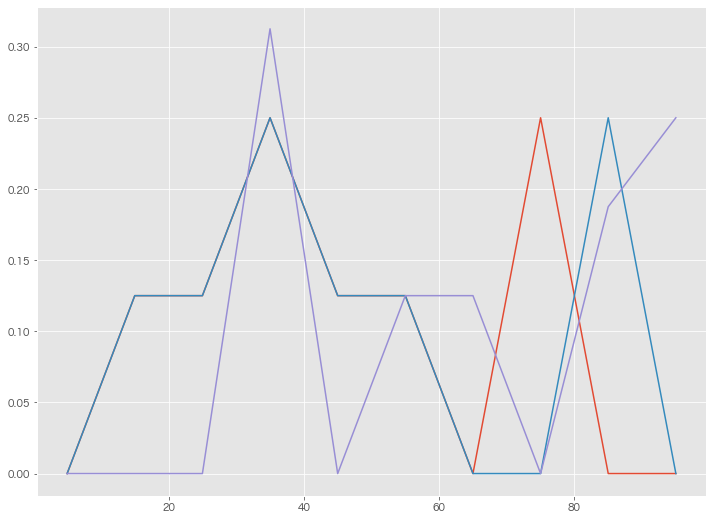

In [69]:
plt.plot(class_value, t_T_num)
plt.plot(class_value, t_Q_num)
plt.plot(class_value, i_Q_num)

In [70]:
print(distance.euclidean(t_T_num, t_Q_num))
print(distance.euclidean(t_T_num, i_Q_num))

0.3535533905932738
0.4759858191164943


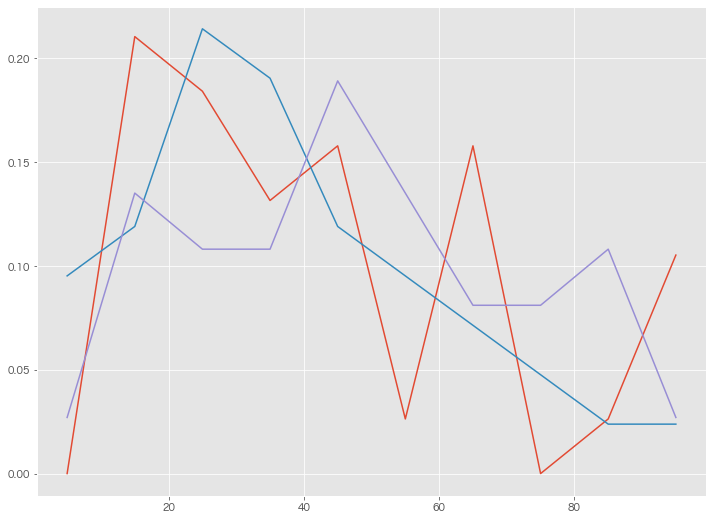

In [9]:
plt.plot(class_value, date_num[0])
plt.plot(class_value, date_num[1])
plt.plot(class_value, date_num[2])

In [36]:
date_num_2 = {}

for i in range(0, 7):
    baa = pd.DataFrame(
        df.loc[(df["User"] == "Isshin") & (df["state"] == "ON") & (df["weekday"] == i)][
            "battery"
        ].copy()
    )
    freq_pra = baa["battery"].value_counts(bins=bins, sort=False)
    rel_freq_pra = freq_pra / baa["battery"].count()
    date_num_2[i] = rel_freq_pra.values

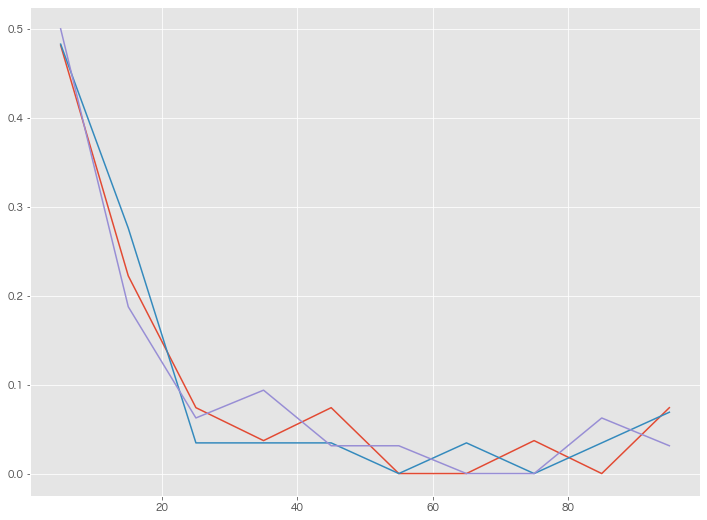

In [37]:
plt.plot(class_value, date_num_2[0])
plt.plot(class_value, date_num_2[1])
plt.plot(class_value, date_num_2[2])

In [38]:
date_num_3 = {}

for i in range(0, 7):
    baa = pd.DataFrame(
        df.loc[(df["User"] == "Ayumi") & (df["state"] == "ON") & (df["weekday"] == i)][
            "battery"
        ].copy()
    )
    freq_pra = baa["battery"].value_counts(bins=bins, sort=False)
    rel_freq_pra = freq_pra / baa["battery"].count()
    date_num_3[i] = rel_freq_pra.values

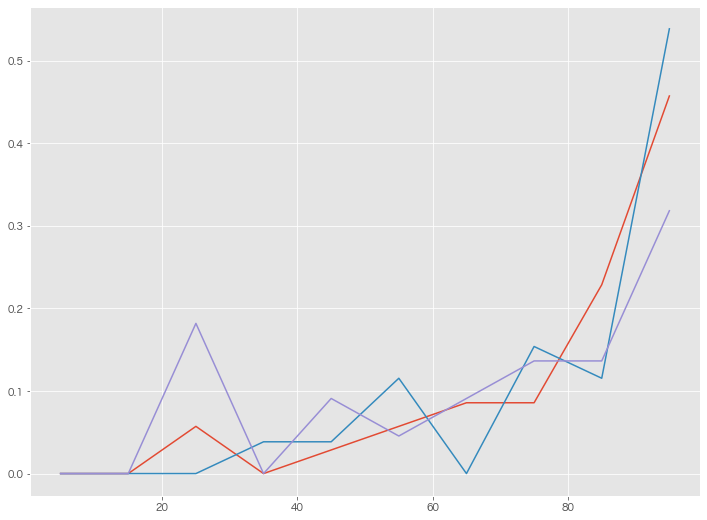

In [39]:
plt.plot(class_value, date_num_3[0])
plt.plot(class_value, date_num_3[1])
plt.plot(class_value, date_num_3[2])

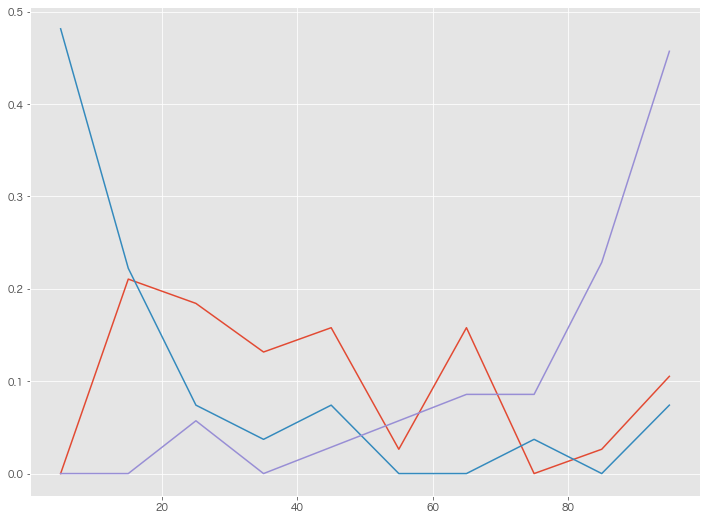

In [42]:
plt.plot(class_value, date_num[0])
plt.plot(class_value, date_num_2[0])
plt.plot(class_value, date_num_3[0])